Reproduce: SimPEG
==================

## Geoscientific Problem

Here, we inverted total magnetic intensity (TMI) data collected over a block within a homogeneous halfspace. We invert for a compact and blocky model using an iteratively re-weighted least-squares inversion approach. The problem is bounded to enforce positivity in the recovered susceptibility model.

The true model consists of a susceptible block (0.025 SI) within a minimally susceptible halfspace (0.0001 SI).
The dimensions of the block in the x, y and z directions were are all 200 m. The block was buried at a depth of 200 m. The Earth's inducing field had an inclination of 65 degrees, a declination of 25 degrees and an intensity of 50,000 nT.

The data being inverted were generated using the [UBC MAG3D v6.0 code](https://mag3d.readthedocs.io/en/v6/). Synthetic TMI data were simulated within a 1000 m by 1000 m region at an elevation of 30 m; the center of which lied directly over the center of the block. The station spacing was 50 m in both the X and Y directions. Observed data were sythnetically created by adding Gaussian noise with a standard deviation of 1 nT to the simulated data. A floor uncertainty of 1 nT was assigned to the observed data.

## SimPEG Package Details

**Link to the docstrings for the simulation class** The docstrings will have a citation and show the integral equation.

## Running the Inversion

We begin by importing all necessary Python packages for running the notebook.

In [1]:
from SimPEG import dask
from SimPEG.potential_fields import magnetics
from SimPEG.utils import plot2Ddata
from SimPEG.utils.io_utils import read_mag3d_ubc, write_mag3d_ubc
from SimPEG import maps, data, data_misfit, regularization, optimization, inverse_problem, inversion, directives
from discretize import TensorMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({"font.size": 14})
write_output = True

A compressed folder containing the assets required to run the notebook is then downloaded. This includes the mesh, true model, and observed data files.

In [2]:
# Download .tar file

Extracted files are then loaded into the SimPEG framework.

In [3]:
rootdir = './../../../assets/magnetics/block_halfspace_tmi_inv_sparse_simpeg/'
meshfile = rootdir + 'mesh.txt'
truemodelfile = rootdir + 'true_model.sus'
obsfile = rootdir + 'dobs.mag'
sensitivitydir = './block_halfspace_tmi_inv_sparse_simpeg/'

mesh = TensorMesh.read_UBC(meshfile)
true_model = TensorMesh.read_model_UBC(mesh, truemodelfile)
mag_data = read_mag3d_ubc(obsfile)

We then plot the observed data and the mesh on which we will recover a susceptibility model.

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\devin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


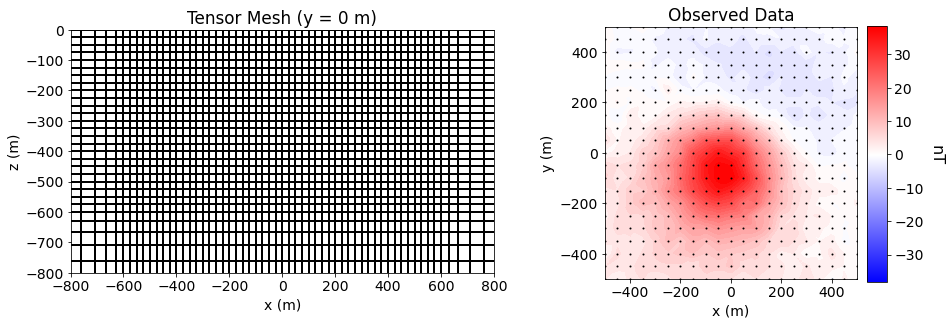

In [4]:
fig = plt.figure(figsize=(14, 4.5))

ax11 = fig.add_axes([0.1, 0.15, 0.42, 0.75])
ind = int(mesh.shape_cells[1]/2)
nan_array = np.zeros(len(true_model))
nan_array[:] = np.NaN
mesh.plot_slice(nan_array, normal='Y', ind=ind, grid=True, ax=ax11)
ax11.set_xlim([-800, 800])
ax11.set_ylim([-800, 0])
ax11.set_title("Tensor Mesh (y = 0 m)")
ax11.set_xlabel("x (m)")
ax11.set_ylabel("z (m)")

ax21 = fig.add_axes([0.63, 0.12, 0.25, 0.8])
xyz = mag_data.survey.receiver_locations
max_val = np.max(np.abs(mag_data.dobs))
plot2Ddata(
    xyz, mag_data.dobs, ax=ax21, dataloc=True, ncontour=50,
    clim=(-max_val, max_val), contourOpts={"cmap": "bwr"}
)
ax21.set_title("Observed Data")
ax21.set_xlabel("x (m)")
ax21.set_ylabel("y (m)")
ax22 = fig.add_axes([0.89, 0.12, 0.02, 0.79])
norm = mpl.colors.Normalize(vmin=-max_val, vmax=max_val)
cbar = mpl.colorbar.ColorbarBase(
    ax22, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("nT", rotation=270, labelpad=20, size=16)

plt.show()

Next, we define the mapping from the model space to the mesh and the simulation. This problem is relatively small so the sensitivity matrix can be stored to disk.

In [5]:
chi_map = maps.IdentityMap(nP=mesh.nC)

simulation = magnetics.simulation.Simulation3DIntegral(
    survey=mag_data.survey,
    mesh=mesh,
    chiMap=chi_map,
    store_sensitivities="disk",
    sensitivity_path=sensitivitydir
)

We now define a starting model and reference model for the inversion.

In [6]:
# Starting and reference model
mref = 1e-4*np.ones(mesh.nC)
m0 = 1e-4*np.ones(mesh.nC)

Here we define the measure of data misfit, the regularization and the algorithm used to compute the step-direction at each iteration. These are used to define the inverse problem.

In [7]:
dmis = data_misfit.L2DataMisfit(data=mag_data, simulation=simulation)

reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.Sparse(
    mesh, mapping=reg_map, reference_model=mref, gradient_type='components',
    alpha_s=2.5e-4, alpha_x=1, alpha_y=1, alpha_z=1
)
reg.norms = np.r_[0., 1., 1., 1.]

opt = optimization.ProjectedGNCG(
    maxIter=50, maxIterCG=50, lower=0.
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

Here, we define the directives for the inversion

In [8]:
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e2)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=30, chifact_start=1.
)
update_jacobi = directives.UpdatePreconditioner()
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=True)

directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_IRLS,
    update_jacobi,
]

Finally, we define and run the inversion.

In [9]:
inv = inversion.BaseInversion(inv_prob, directives_list)
simpeg_model = inv.run(m0)

simpeg_model = chi_map*simpeg_model
dpred = inv_prob.dpred


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.55e+06  2.04e+04  0.00e+00  2.04e+04    5.03e+05      0              
   1  1.39e+06  1.80e+03  5.20e-04  2.52e+03    1.18e+05      0              
   2  3.47e+05  3.31e+02  9.39e-04  6.57e+02    3.94e+04      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.0029561915184348484
   3  8.67e+04  1.31e+02  1.87e-03  2.93e+02    1.45e+04      0   Skip BFGS  
   4  1.10e+05  7.14e+01  2.80e-03  3.81e+02    6.89e+03      0   Skip BFGS  
   5  1.23e+05  8.91e+01  3.1

If desired, we can output the recovered model and the predicted data.

In [10]:
if write_output:
    TensorMesh.write_model_UBC(mesh, rootdir+'recovered_model.sus', simpeg_model)
    data_dpred = data.Data(survey=mag_data.survey, dobs=dpred)
    write_mag3d_ubc(rootdir+'dpred.mag', data_dpred)

Observation file saved to: ./../../../assets/magnetics/block_halfspace_tmi_inv_sparse_simpeg/dpred.mag


## Plotting Data Misfit

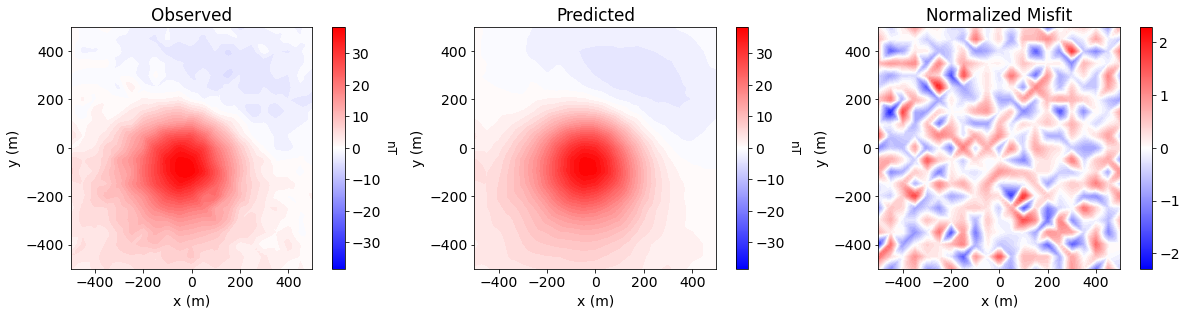

In [11]:
data_array = np.c_[mag_data.dobs, dpred, (mag_data.dobs - dpred) / mag_data.standard_deviation]

fig = plt.figure(figsize=(17, 4))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["nT", "nT", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [
    np.max(np.abs(mag_data.dobs)),
    np.max(np.abs(mag_data.dobs)),
    np.max(np.abs(data_array[:, 2]))
]

for ii in range(0, 3):

    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.25, 0.84])
    cplot[ii] = plot2Ddata(
        xyz,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=50,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "bwr"}
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.27, 0.11, 0.01, 0.84])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()

## Comparing the True Model and Recovered Model

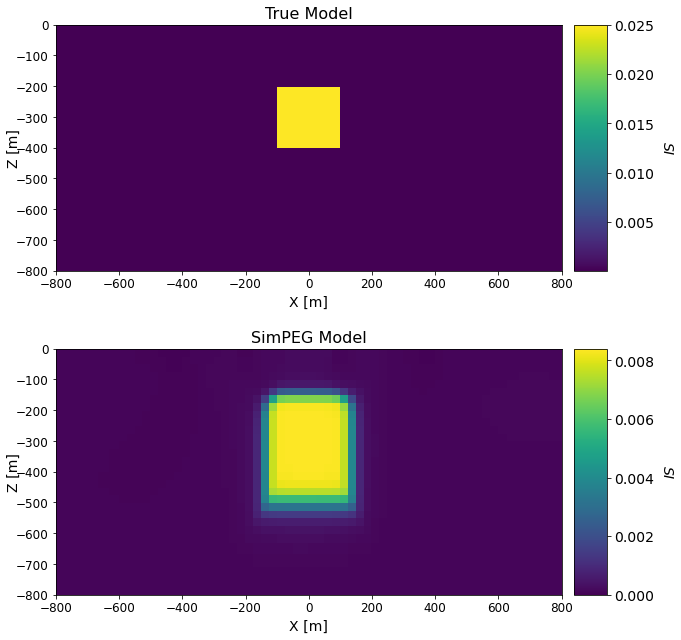

In [12]:
fig = plt.figure(figsize=(9, 9))
font_size = 14

models_list = [true_model, simpeg_model]
titles_list = ['True Model', 'SimPEG Model']
ax1 = 2*[None]
cplot = 2*[None]
ax2 = 2*[None]
cbar = 2*[None]

for qq in range(0, 2):
    ax1[qq] = fig.add_axes([0.1, 0.55 - 0.5*qq, 0.78, 0.38])
    
    cplot[qq] = mesh.plot_slice(
        models_list[qq], normal='Y', ind=int(mesh.shape_cells[1]/2), grid=False, ax=ax1[qq]
    )
    cplot[qq][0].set_clim((np.min(models_list[qq]), np.max(models_list[qq])))
    ax1[qq].set_xlim([-800, 800])
    ax1[qq].set_ylim([-800, 0])
    ax1[qq].set_xlabel("X [m]", fontsize=font_size)
    ax1[qq].set_ylabel("Z [m]", fontsize=font_size, labelpad=-5)
    ax1[qq].tick_params(labelsize=font_size - 2)
    ax1[qq].set_title(titles_list[qq], fontsize=font_size + 2)
    
    ax2[qq] = fig.add_axes([0.9, 0.55 - 0.5*qq, 0.05, 0.38])
    norm = mpl.colors.Normalize(vmin=np.min(models_list[qq]), vmax=np.max(models_list[qq]))
    cbar[qq] = mpl.colorbar.ColorbarBase(
        ax2[qq], norm=norm, orientation="vertical"
    )
    cbar[qq].set_label(
        "$SI$",
        rotation=270,
        labelpad=20,
        size=font_size,
)

plt.show()